# CrossValidation

## Data

In [1]:
from data import Data
import numpy as np

full_train = Data(data_type='train')
# test_data = Data(data_type='test')

print(full_train.x.shape)

Loading train data 18662/18662: 100%|█████████████████████████████████████████████████████████████ [ time left: 00:00 ]


(18662, 1000, 102)


## K-fold

fold 0
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1000, 180)         138960    
_________________________________________________________________
global_max_pooling1d (Global (None, 180)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               23168     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________
Train on 16329 samples, validate on 2333 samples
Epoch 1/200
16329/16329 - 43s - loss: 0.4487 - accuracy: 0.8

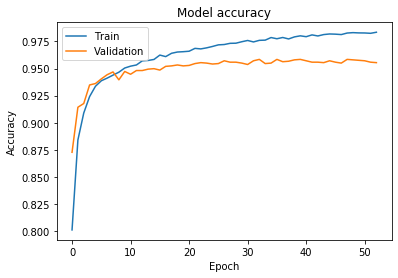

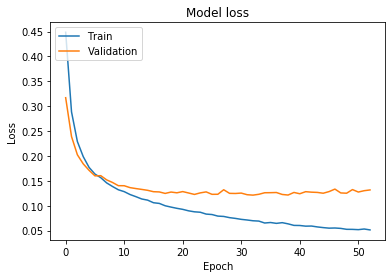

2333/1 - 3s - loss: 0.0788 - accuracy: 0.9584 - auc: 0.9903
accuracy: 95.84%
fold 1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1000, 180)         138960    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 180)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               23168     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________
Train on 16329 samples, valida

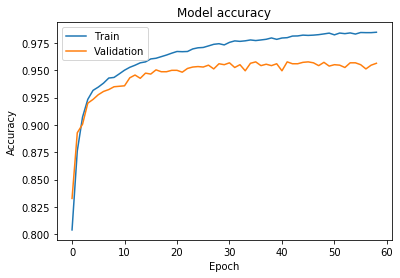

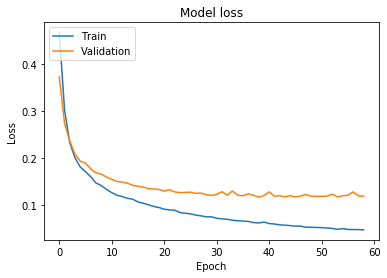

2333/1 - 3s - loss: 0.1209 - accuracy: 0.9541 - auc: 0.9902
accuracy: 95.41%
fold 2
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 1000, 180)         138960    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 180)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               23168     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________
Train on 16329 samples, valida

In [ ]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
import numpy,os
import matplotlib.pyplot as plt
# import csv
# import math
# from data import Data

%matplotlib inline
# fix random seed for reproducibility
seed = 5242
numpy.random.seed(seed)
# load pima indians dataset
# dataset = numpy.loadtxt("pima-indians-diabetes.csv", delimiter=",")
# split into input (X) and output (Y) variables
# X = dataset[:,0:8]
# Y = dataset[:,8]
# define 10-fold cross validation test harness
splits = 8

kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)
cvscores = []
fold = 0
for train, test in kfold.split(full_train.x, full_train.y):
    print('fold '+str(fold))

    model_name = 'lstm_pool_8_split'
    
    # create model
    model = Sequential()
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(90,return_sequences=True),input_shape=(1000,102)))
    model.add(tf.keras.layers.GlobalMaxPooling1D())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.1))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.summary()
    
    checkpoint_dir = './cross_validation/' + model_name+ '_fold'+ str(fold)
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

    checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_prefix,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True)

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        min_delta=0, 
        patience=20, 
        mode='auto', 
        restore_best_weights=True)
 
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(5e-5,0.9,0.999), 
                  metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
    # Fit the model
    history = model.fit(full_train.x[train], full_train.y[train], validation_data=(full_train.x[test],full_train.y[test]), 
              epochs=200, batch_size=32, verbose=2,callbacks=[checkpoint_callback,early_stopping_callback],shuffle=True)
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # evaluate the model
    scores = model.evaluate(full_train.x[test], full_train.y[test], verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    
    fold += 1
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

In [ ]:
model = Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True),input_shape=(1000,102)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

checkpoint_dir = './cross_validation/' + model_name+ '_fold'+ str(fold)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# Compile model
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

import numpy as np
from data import Data

test_data = Data(data_type='test')
print("Test data: x:"+ str(test_data.x.shape)+ ' y:'+str(test_data.y.shape))

for fold in range(splits):
    checkpoint_dir = './cross_validation/' + model_name+ '_fold'+ str(fold)
    model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
    if fold == 0:
        predictions = model.predict(test_data.x)
    else:
        predictions = np.concatenate((predictions,model.predict(test_data.x)),axis=1)
print(predictions.shape)

avg_predictions = np.mean(predictions, axis=1)
print(avg_predictions.shape)

import csv

output_file = 'result_cv_' + model_name + '.csv'
with open(output_file, 'wt', newline='', encoding='utf-8') as output_file:
    csv_writer = csv.writer(output_file)
    csv_writer.writerow(('Id', 'Predicted'))
    for id, predict in enumerate(avg_predictions):
        csv_writer.writerow((id, predict))
print('Saved to '+'result_cv_' + model_name + '.csv')